# STATS 607
## Week 5.1: Cluster computing

In [4]:
from wetterdienst import Wetterdienst

Wetterdienst.discover()

{'DWD': ['OBSERVATION', 'MOSMIX', 'DMO', 'ROAD', 'RADAR'],
 'ECCC': ['OBSERVATION'],
 'IMGW': ['HYDROLOGY', 'METEOROLOGY'],
 'NOAA': ['GHCN'],
 'WSV': ['PEGEL'],
 'EA': ['HYDROLOGY'],
 'NWS': ['OBSERVATION'],
 'EAUFRANCE': ['HUBEAU'],
 'GEOSPHERE': ['OBSERVATION']}

In [6]:
API = Wetterdienst(provider="noaa", network="ghcn")

In [155]:
import datetime as dt
from wetterdienst import Resolution, Period
from wetterdienst.provider.noaa.ghcn import NoaaGhcnRequest, NoaaGhcnParameter



request = NoaaGhcnRequest(
    parameter=["TMAX"],
    resolution=NoaaGhcnParameter.DAILY,
    start_date=dt.datetime(1980, 1, 1),
    end_date=dt.datetime(2021, 1, 20)
)


In [158]:
a2 = (42.2808, -83.7430)
stations = request.filter_by_distance(latlon=a2, distance=200, unit="mi")
stations

StationsResult(df=shape: (3_863, 9)
┌─────────────┬─────────────┬────────────┬──────────┬───┬────────┬────────────┬───────┬────────────┐
│ station_id  ┆ start_date  ┆ end_date   ┆ latitude ┆ … ┆ height ┆ name       ┆ state ┆ distance   │
│ ---         ┆ ---         ┆ ---        ┆ ---      ┆   ┆ ---    ┆ ---        ┆ ---   ┆ ---        │
│ str         ┆ datetime[μs ┆ datetime[μ ┆ f64      ┆   ┆ f64    ┆ str        ┆ str   ┆ f64        │
│             ┆ , UTC]      ┆ s, UTC]    ┆          ┆   ┆        ┆            ┆       ┆            │
╞═════════════╪═════════════╪════════════╪══════════╪═══╪════════╪════════════╪═══════╪════════════╡
│ USC00200220 ┆ 2008-01-01  ┆ 2013-12-31 ┆ 42.2875  ┆ … ┆ 263.7  ┆ ANN ARBOR  ┆ MI    ┆ 1.664958   │
│             ┆ 00:00:00    ┆ 00:00:00   ┆          ┆   ┆        ┆ 1W         ┆       ┆            │
│             ┆ UTC         ┆ UTC        ┆          ┆   ┆        ┆            ┆       ┆            │
│ US1MIWS0016 ┆ 2008-01-01  ┆ 2012-12-31 ┆ 42.2973  ┆ …

In [164]:
import pandas as pd
inv = pd.read_fwf("https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt", 
                 names=["station_id", "lat", "long", "variable", "start_year", "end_year"])


In [175]:
inv.query("variable == 'TMAX'")

,station_id,lat,long,variable,start_year,end_year
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
11,ACW00011647,17.1333,-61.7833,TMAX,1961,1961
18,AE000041196,25.3330,55.5170,TMAX,1944,2024
22,AEM00041194,25.2550,55.3640,TMAX,1983,2024
26,AEM00041217,24.4330,54.6510,TMAX,1983,2024
...,...,...,...,...,...,...
756921,ZI000067969,21.0500,29.3670,TMAX,1962,1990
756924,ZI000067975,20.0670,30.8670,TMAX,1951,2024
756929,ZI000067977,21.0170,31.5830,TMAX,1968,1990
756932,ZI000067983,20.2000,32.6160,TMAX,1951,2020


In [180]:
mucho_data = stations.df.join(pl.from_pandas(inv.query("variable == 'TMAX'")), on="station_id").filter(
    pl.col("start_year") < 1980, pl.col("end_year") > 2020
)

In [181]:
stations = mucho_data['station_id'].to_list()
open("snakemake/stations.txt", "wt").write("\n".join(stations))

1847

In [184]:
    request = NoaaGhcnRequest(
        parameter=["TMAX"],
        resolution=NoaaGhcnParameter.DAILY,
        start_date=dt.datetime(1980, 1, 1),
        end_date=dt.datetime(2021, 1, 20)
    )
    stations = request.filter_by_station_id(station_id='CA006124127')

In [188]:
res = next(stations.values.query())

## Examining data

In [11]:
df["date"] = df["date"].dt.to_period("M")

/tmp/ipykernel_2147929/116874308.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["date"] = df["date"].dt.to_period("M")


In [12]:
df.groupby("date")["value"].mean() / 10

date
1980-01    27.319722
1980-02    27.177919
1980-03    27.789281
1980-04    28.644142
1980-05    29.497214
             ...    
2020-09    29.631766
2020-10    28.858261
2020-11    28.563164
2020-12    27.662055
2021-01    27.510219
Freq: M, Name: value, Length: 493, dtype: float64

In [15]:
series = df.groupby("date")["value"].mean() / 10

<Axes: xlabel='date'>

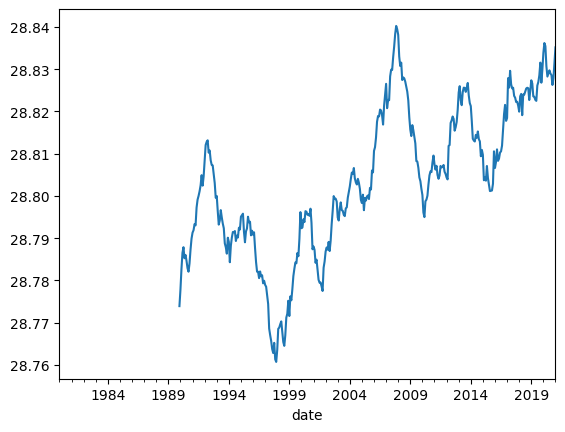

In [21]:
series.rolling(window=120).mean().plot()

## Hierarchical model

For each station $i$, observed temperature $y_{it}$ at time $t$ is modeled as:
$$
y_{it} = \beta_{i,0} + \beta_{i,1} t + \epsilon_{it}, \quad \epsilon_{it} \sim \mathcal{N}(0, \sigma_i^2)
$$
where:
- $\beta_{i,0}$: Station-specific intercept,
-  $\beta_{i,1}$: Station-specific trend (slope),
- $\sigma_i^2$: Station-specific variance.



Priors for station-level parameters:

$$
\begin{align}
\beta_{i,1} & \sim \mathcal{N}(\mu_{\text{region}}, \tau^2) \\
\beta_{i,0} & \sim \mathcal{N}(0, 10^2)  \\
\sigma_i &\sim \text{Half-Cauchy}(0, 5)
\end{align}
$$

## Regional means
We will borrow strength across different stations by imposing region-level correlations:

$$
\mu_{\text{region}} \sim \mathcal{N}(\mu_{\text{global}}, \sigma_{\text{region}}^2)
$$
where:
-  $\mu_{\text{region}}$: Mean trend for the region,
- $\sigma_{\text{region}}^2$: Variance in trends across regions.


## Global mean
The global trend is modeled as:
$$
\begin{align}
\mu_{\text{global}} &\sim \mathcal{N}(0, 10^2) \\
\sigma_{\text{region}} &\sim \text{Half-Cauchy}(0, 5)
\end{align}
$$


## Full model



$$
\begin{align}
y_{it} &\sim \mathcal{N}(\beta_{i,0} + \beta_{i,1} t, \sigma_i^2) \\
\beta_{i,1} &\sim \mathcal{N}(\mu_{\text{region}}, \tau^2) \\
\mu_{\text{region}} &\sim \mathcal{N}(\mu_{\text{global}}, \sigma_{\text{region}}^2) \\
\mu_{\text{global}} &\sim \mathcal{N}(0, 10^2) \\
\sigma_i, \sigma_{\text{region}}, \tau &\sim \text{Half-Cauchy}(0, 5)
\end{align}
$$


In [64]:
import numpyro
import numpyro.distributions as dist

def hierarchical_model(year, temperature, station_idx, n_stations):
    # Global-level parameters
    mu_global = numpyro.sample("mu_global", dist.Normal(0, 10))
    sigma_region = numpyro.sample("sigma_region", dist.HalfCauchy(5))
    
    # Region-level trend (for simplicity, modeled as a single region)
    mu_region = numpyro.sample("mu_region", dist.Normal(mu_global, sigma_region))
    
    # Station-level parameters
    tau_station = numpyro.sample("tau_station", dist.HalfCauchy(5))
    beta_1_station = numpyro.sample("beta_1_station", dist.Normal(mu_region, tau_station).expand([n_stations]))
    beta_0_station = numpyro.sample("beta_0_station", dist.Normal(0, 10).expand([n_stations]))
    sigma_station = numpyro.sample("sigma_station", dist.HalfCauchy(5).expand([n_stations]))
    
    # Observation model
    temperature_hat = beta_0_station[station_idx] + beta_1_station[station_idx] * year
    numpyro.sample("obs", dist.Normal(temperature_hat, sigma_station[station_idx]), obs=temperature)

In [82]:
summary_df = df.groupby(["station_id", "date"]).agg({'value': 'mean'}).reset_index().dropna()

In [83]:
y = summary_df['value'].values
t = summary_df['date'].astype('int').values

In [84]:
# Encode station IDs as integers
stations = summary_df['station_id'].unique()
station_idx = {s: i for i, s in enumerate(stations)}
summary_df['station_idx'] = summary_df['station_id'].map(station_idx)
station_idx = summary_df['station_idx'].values

In [85]:
n_stations = len(stations)

In [ ]:
from numpyro.infer import MCMC, NUTS, Predictive

nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000)

# Random number seed
import jax

rng_key = jax.random.PRNGKey(0)

# Run MCMC
mcmc.run(rng_key, year=t, temperature=y, station_idx=station_idx, n_stations=n_stations)

# Extract samples
posterior_samples = mcmc.get_samples()

In [1]:
from numpyro.infer import SVI, Trace_ELBO

# Define the guide
guide = numpyro.infer.autoguide.AutoNormal(hierarchical_model)

NameError: name 'numpyro' is not defined